In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')

sns.set_context("paper",rc={"lines.linewidth": 1.5})
# rc('text', usetex=True)
sns.set(font_scale=1.5, style="white")  # sets font scale

import sys
sys.path.insert(0, '/home/neild/cloud/LionsMarkTwo/src/synthetic')

### For vanilla inference

In [2]:
from __future__ import division
from builtins import range
import numpy as np
np.seterr(divide='ignore') # these warnings are usually harmless for this code
np.random.seed(0)
import pyhsmm
from pyhsmm.util.text import progprint_xrange
# Hamming distance
from scipy.spatial.distance import hamming as HD
import random

In [3]:
HD([1,1,1],[1,1,0])

0.33333333333333331

## Load data

In [3]:
#data 
# dataDir='/home/neild/cloud/LionsMarkTwo/src/synthetic/'
dataDir='/home/nd/cloud/LionsMarkTwo/src/synthetic/'
YS = {}
YS['signal'] =  pd.read_csv(dataDir + 'UAI-synthetic-emissions-experiment.csv',header=None)

# load ground truth
XS = {}
XS['ground'] = pd.read_csv(dataDir + 'UAI-synthetic-emissions-ground-truth.csv',
                           header=None,
                           usecols=[0])

# Vanilla models and inference

In [4]:
# Function to remap series
def map2lowest2(df):
    if not isinstance(df,pd.DataFrame):
        df = pd.DataFrame(df)
    k = np.unique(df)
    K = range(len(k))
    dictionary = dict(zip(k, K))
    return df.replace(dictionary),len(k)

In [13]:
# which random seed
seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

('Seed was:', 2272342451797220214L)


In [16]:
%%time

#########################
#  posterior inference  #
#########################

# Set the weak limit truncation level
Nmax = 20
obs_dim = YS['signal'].shape[1]
# and some hyperparameters
obs_hypparams = {'mu_0':YS['signal'].values.mean(axis=0),
                'sigma_0':0.75 * np.cov(YS['signal'].values, rowvar=False),
                'kappa_0':0.1,
                'nu_0':obs_dim+2}
dur_hypparams = {'alpha_0':2*50,
                 'beta_0':2}

obs_distns = [pyhsmm.distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
dur_distns = [pyhsmm.distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

# hdp-hmm
# posteriormodel = pyhsmm.models.WeakLimitHDPHMM(
#         # NOTE: instead of passing in alpha_0 and gamma_0, we pass in parameters
#         # for priors over those concentration parameters
#         alpha_a_0=1.,alpha_b_0=1.,
#         gamma_a_0=1.,gamma_b_0=1.,
#         init_state_concentration=5.,
#         obs_distns=obs_distns)

# sticky hdp-hmm
# posteriormodel = pyhsmm.models.WeakLimitStickyHDPHMM(
#         alpha_a_0=1.,alpha_b_0=1.,
#         gamma_a_0=1.,gamma_b_0=1.,
#         kappa=50.,
#         init_state_concentration=5.,
#         obs_distns=obs_distns)

# hdp-hsmm
posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
        alpha_a_0=1.,alpha_b_0=1.,
        gamma_a_0=1.,gamma_b_0=1.,
        init_state_concentration=5.,
        obs_distns=obs_distns,dur_distns=dur_distns)

posteriormodel.add_data(YS['signal'].values,trunc=110)
HammingDistance = {}
stateCardinality = {}
N = YS['signal'].shape[0]
gt = XS['ground'].values.flatten()[:-1]
samples = ["10","100","1000"]
for s in samples:
    HammingDistance[s] = []
    stateCardinality[s] = []
chains = 10
maxIter = 100

for c in range(chains):
    for idx in range(maxIter+1):#progprint_xrange(s,show_times=True):
        posteriormodel.resample_model()
        # Get HD score per Gibbs sample
        if idx % 100 == 0:
            # Print every 50th iteration to see where we are.
            print('Current MCMC iteration:',idx)
        if str(idx) in samples:
            a,b = map2lowest2(posteriormodel.stateseqs[0])
            HammingDistance[str(idx)].append(int(N*HD(a,gt)))
            stateCardinality[str(idx)].append(b)
    print("Chain:",c)

('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 0)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 1)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 2)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 3)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 4)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 5)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 6)
('Current MCMC iteration:', 0)
('Current MCMC iteration:', 100)
('Chain:', 7)
('Current MCMC iteration:', 0)


MemoryError: 

In [17]:
print(HammingDistance,stateCardinality)

({'10': [637, 669, 673, 662, 671, 653, 665, 650], '100': [655, 668, 640, 684, 659, 652, 674, 678], '1000': []}, {'10': [3, 3, 3, 3, 3, 3, 3, 3], '100': [3, 3, 3, 3, 3, 3, 3, 3], '1000': []})


In [32]:
# build new dict
HammingDistance = {'100': [160, 139, 158, 683, 356, 682, 
                           662,696, 706, 697, 704, 373, 153, 167, 143], 
                   '10': [133, 120, 141, 670, 436, 675, 666,
                          772, 696, 708, 704, 433, 377, 161, 144]}
stateCardinality = {'100': [3, 3, 3, 3, 4, 5, 3, 4, 4, 4, 4, 2, 3, 3, 3], 
                     '10': [3, 3, 3, 3, 5, 5, 3, 4, 4, 4, 4, 2, 2, 3, 3]}

In [34]:
import csv
with open('hdphsmm_hd.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    w.writerow(HammingDistance.keys())
    w.writerows(zip(*HammingDistance.values()))
f.close()

with open('hdphsmm_sc.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    w.writerow(stateCardinality.keys())
    w.writerows(zip(*stateCardinality.values()))
f.close()

## Plots prelims

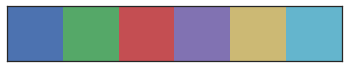

In [5]:
kernelcolours = list( sns.color_palette()[i] for i in [5,1,2,3] )
sns.palplot(sns.color_palette())
mypalette=sns.color_palette("autumn", n_colors=4)
COLOR = {}
COLOR['HDP-HMM'] = mypalette[0]
COLOR['Sticky HDP-HMM'] = mypalette[2]
COLOR['HSMM-HMM'] = mypalette[1]

# Synthetic data plot

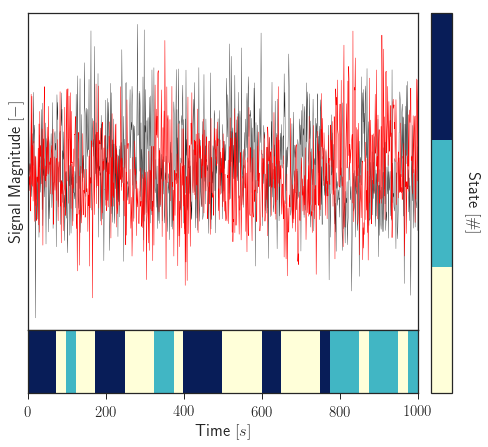

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
mySize=(6,10)
data = YS['signal']

ax1 = plt.subplot2grid(mySize,(0,0),colspan=10,rowspan=5)
ax1.plot(data[0],'k-',lw=0.3,alpha=1)#,label='$y \in \mathbb{R}^2$')
ax1.plot(data[1],'r-',lw=0.5,alpha=1)#,label='$y \in \mathbb{R}^2$')
ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0,data.shape[0])
ax1.set_ylim(data.values.min()-0.5,data.values.max()+0.5)
ax1.set_ylabel('Signal Magnitude $[-]$')
ax1.set_yticks([])
axbox = ax1.get_position()

ax2 = plt.subplot2grid(mySize,(5,0),colspan=10,rowspan=1)
Z = np.array(XS['ground'].transpose())
N = np.amax(Z).astype(np.int64) + 1

cmap = plt.get_cmap('YlGnBu',N)
heatmap = ax2.pcolor(Z, cmap=cmap)
box = ax2.get_position()
axColor = plt.axes([box.x0*0.9 + box.width * 1.05, box.y0, 0.04, box.height*7])
cbar = plt.colorbar(heatmap,cax=axColor)#,fraction=0.092 ,pad=0.01,shrink=1.75)
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('State $[\#]$',  rotation=270)
cbar.solids.set_edgecolor("face")
ax2.set_xlabel('Time $[s]$')
# ax2.set_ylabel('Ground truth [-]')
ax2.set_yticks([])

fig.subplots_adjust(hspace=0.0) # Vertical spacing
plt.show()

In [63]:
fig.savefig('PAPER-synthetic-data' + '.pdf',bbox_inches='tight')

# Duration distribution plot

In [ ]:
np.random.d

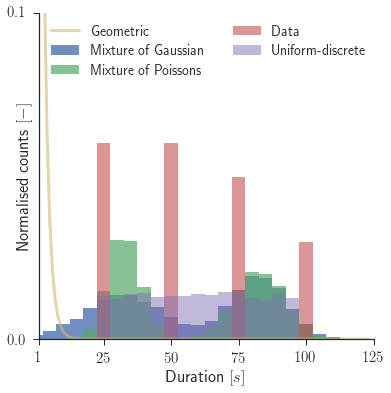

In [3]:
fig, ax = plt.subplots(figsize=(6,6))

samples = 10000
# Duration distributions
myLabels = ['Mixture of Gaussian','Mixture of Poissons',
            'Data', 'Uniform-discrete']
myDurations = {}
durations = ['gaussian','poisson','data','uniform-discrete']
# Mixture 
myDurations[durations[0]] = np.concatenate([np.random.normal(35,15,size=samples),
                                            np.random.normal(85,10,size=samples)])
# Mixture
myDurations[durations[1]] = np.concatenate([np.random.poisson(35,size=samples),
                                            np.random.poisson(85,size=samples)])
elements = [25, 50, 75, 100]
probabilites = [0.3, 0.3, 0.25, 0.15]
myDurations[durations[2]] = np.random.choice(elements, samples, p=probabilites)
myDurations[durations[3]] = np.random.uniform(25,100,samples)
alphas = [0.8, 0.7, 0.6, 0.5]
for i,j in enumerate(durations):
    ax.hist(myDurations[j],
            bins=np.arange(0,125,5),
            histtype='bar',
            align='left',
            normed='True',
            label=myLabels[i], 
            alpha=alphas[i])
maxx = 125    
p = 0.6    
ax.plot((1-p)**(np.arange(1,maxx,1)*p),lw=3, alpha=0.6,label='Geometric')
ax.set_xticks([1, 25, 50, 75, 100, maxx])
ax.set_xlim(1,maxx)
ax.set_xlabel('Duration $[s]$')
ax.set_ylim(0,0.1)
ax.set_ylabel('Normalised counts $[-]$',labelpad=-25)
ax.set_yticks([0.0,0.1])
# axbox = ax1.get_position()
ax.legend(loc= 'upper left',#(axbox.x0 - 0.225, axbox.y0 + 0.35),
           ncol=2,
           prop={'size':14})
sns.despine()
plt.show()

In [4]:
fig.savefig('PAPER-duration-distributions' + '.pdf',bbox_inches='tight')

# Hamming distance plot

In [9]:
# Function to remap series
def map2lowest(df):
    k = np.unique(df)
    K = range(len(k))
    dictionary = dict(zip(k, K))
    return df.replace(dictionary)

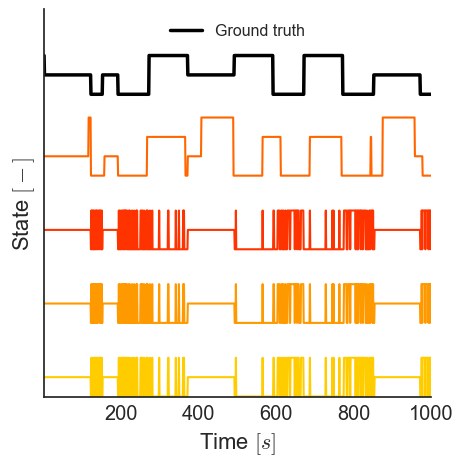

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
mySize=(4,10)
mylw = 1.5
spac = 1.9

ax1 = plt.subplot2grid(mySize,(0,0),colspan=10,rowspan=4)
ax1.plot(XS['ground']*0.5+4*spac + 0.2,color='k',lw=mylw+1,alpha=1,label='Ground truth')
ax1.plot(map2lowest(XS['hdpedhmm'])*0.5+3*spac,color=COLOR['HDP-EDHMM'],lw=mylw,alpha=1)
ax1.plot(map2lowest(XS['hdphmm'])*0.5+2*spac,color=COLOR['HDP-HMM'],lw=mylw,alpha=1)
ax1.plot(map2lowest(XS['hdphmm'])*0.5+spac,color=COLOR['Sticky HDP-HMM'],lw=mylw,alpha=1)
ax1.plot(map2lowest(XS['hdphmm'])*0.5,color=COLOR['Stateful HDP-HMM'],lw=mylw,alpha=1)
# ax1.get_xaxis().set_visible(False)
ax1.set_xticks([200, 400, 600,800,1000])
ax1.set_xlim(0,1000)
ax1.set_xlabel('Time $[s]$')
ax1.set_ylim(0,10)
ax1.set_ylabel('State $[-]$')
ax1.set_yticks([])
axbox = ax1.get_position()
ax1.legend(loc= 'upper center',#(axbox.x0 - 0.225, axbox.y0 + 0.35),
           ncol=2,
           prop={'size':11.5})
sns.despine()
fig.subplots_adjust(hspace=0.3) # Vertical spacing
plt.show()

In [295]:
fig.savefig('state-seq' + '.pdf',bbox_inches='tight')

## All model comparisson plot

In [6]:
import matplotlib.ticker as plticker
from numpy import genfromtxt
import glob

### For viva plots

In [38]:
# Load data
models=['HDPHMM','StickyHDPHMM','HDPHSMM']
model_names=['HDP-HMM','Sticky HDP-HMM','HDP-HSMM']
hd = {}
sc = {}
for i,j in enumerate(models):
    name = j.lower()
    pathFile = glob.glob(name+'_hd.csv')[0]
    hd[j] = pd.read_csv(pathFile)
    hd[j]['model'] = model_names[i]
    pathFile = glob.glob(name+'_sc.csv')[0]
    sc[j] = pd.read_csv(pathFile)
    sc[j]['model'] = model_names[i]
hdDF = pd.concat([hd['HDPHMM'],hd['StickyHDPHMM'],hd['HDPHSMM']], axis=0) 
cDF = pd.concat([sc['HDPHMM'],sc['StickyHDPHMM'],sc['HDPHSMM']], axis=0) 

In [8]:
data = pd.melt(hdDF, "model", var_name="samples")

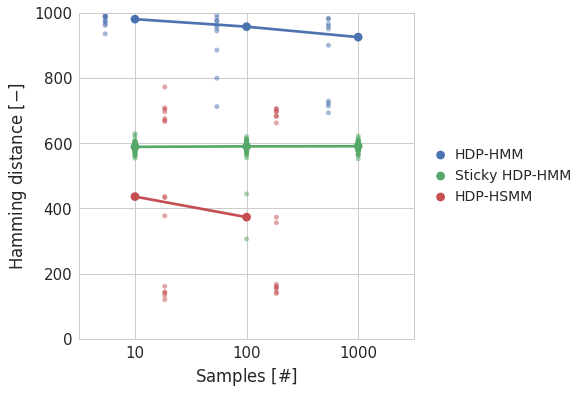

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style('whitegrid')
# sns.despine()

# Show each observation with a scatterplot
sns.stripplot(x="samples", y="value",  hue="model",
              data=data, dodge=True, jitter=False, palette='deep',
              alpha=.5,size=5, marker='o',zorder=1)

# Show the medians
sns.pointplot(x="samples", y="value", hue="model",
              data=data, dodge=0, join=True, palette="deep",
                            estimator=np.median,
              markers="o", scale=0.85, ci=None)

# Tick stuff
ax.set_xlabel('Samples $[\#]$', labelpad=5)
ax.set_ylim(0,1000)
ax.set_ylabel('Hamming distance $[-]$',labelpad=5)
# ax.set_yticks([0.0,0.1])

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:],handletextpad=0, columnspacing=1,
          loc="center left", ncol=1, frameon=False,
          prop={'size':14},bbox_to_anchor=(1.,.5))
ax.grid(True, which='both')
plt.show()

In [37]:
fig.savefig('Hamming-distance-vanilla' + '.pdf',bbox_inches='tight')

### State cardinality plots

In [39]:
data = pd.melt(cDF, "model", var_name="samples")

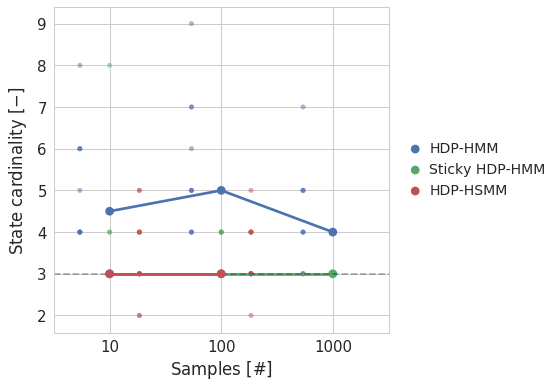

In [43]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style('whitegrid')

# Show each observation with a scatterplot
sns.stripplot(x="samples", y="value",  hue="model",
              data=data, dodge=True, jitter=False, palette='deep',
              alpha=.5,size=5, marker='o',zorder=1)

# Show the conditional means
sns.pointplot(x="samples", y="value", hue="model",
              data=data, dodge=0, join=True, palette="deep",
                            estimator=np.median,
              markers="o", scale=0.85, ci=None)

# red line
plt.axhline(y=3, alpha=0.3,color='k', linestyle='--')

# Tick stuff
ax.set_xlabel('Samples $[\#]$')
# ax.set_ylim(0.5,5.5)
ax.set_ylabel('State cardinality $[-]$',labelpad=8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:],handletextpad=0, columnspacing=1,
          loc="center left", ncol=1, frameon=False,
          prop={'size':14},bbox_to_anchor=(1.,.5))
ax.grid(True, which='both')
plt.show()

In [44]:
fig.savefig('state-cardinality-vanilla' + '.pdf',bbox_inches='tight')

---

In [39]:
# Load data
models=['HDP-HMM','Sticky-HDP-HMM','Stateful-HDP-HMM','IDHMM','Stateful-IDHMM']
hd = {}
myDir = '/home/neild/cloud/LionsMarkTwo/src/synthetic/smc-uniform-discrete/'
for i,j in enumerate(models):
    name = j.lower()
    pathFile = glob.glob(myDir+'hamming-distance-synthetic-'+name+'*.csv')[0]
    hd[j] = genfromtxt(pathFile,delimiter=',')

# Store in dataframe
hdDF = []
cDF = []
cols = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']
for i in models:
    # Hamming distance
    tmp = pd.DataFrame(hd[i][:,::2].transpose(),columns=cols)
    tmp['model'] = i
    # state cardinality
    tmp1 = pd.DataFrame(hd[i][:,::-2].transpose(),columns=cols)
    tmp1['model'] = i
    # Append to global model
    hdDF.append(tmp) # store dataframes in list
    cDF.append(tmp1) # store dataframes in list
hdDF = pd.concat(hdDF, axis=0) 
cDF = pd.concat(cDF, axis=0) 

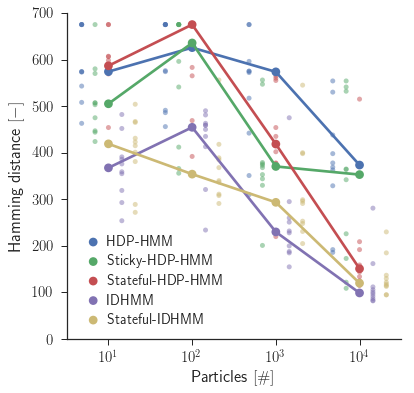

In [276]:
data = pd.melt(hdDF, "model", var_name="particles")
# Initialise
# sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

# Show each observation with a scatterplot
sns.stripplot(x="particles", y="value",  hue="model",
              data=data, dodge=True, jitter=False, palette='deep',
              alpha=.5,size=5, marker='o',zorder=1)

# Show the conditional means
sns.pointplot(x="particles", y="value", hue="model",
              data=data, dodge=0, join=True, palette="deep",
                            estimator=np.median,
              markers="o", scale=0.85, ci=None)

# Tick stuff
ax.set_xlabel('Iteration $[\#]$')
ax.set_ylim(0,700)
ax.set_ylabel('Hamming distance $[-]$',labelpad=8)
# ax.set_yticks([0.0,0.1])

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[5:], labels[5:],handletextpad=0, columnspacing=1,
          loc="lower left", ncol=1, frameon=False,prop={'size':14})

plt.show()

In [277]:
fig.savefig('Hamming-distance' + '.pdf',bbox_inches='tight')

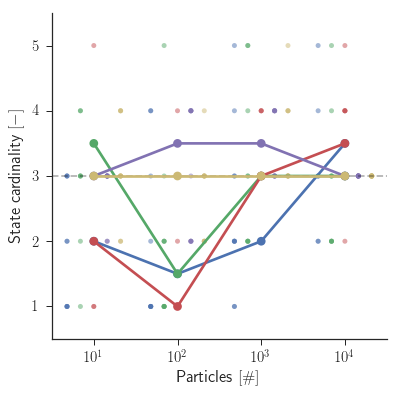

In [279]:
data = pd.melt(cDF, "model", var_name="particles")
# Initialise
# sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

# Show each observation with a scatterplot
sns.stripplot(x="particles", y="value",  hue="model",
              data=data, dodge=True, jitter=False, palette='deep',
              alpha=.5,size=5, marker='o',zorder=1)

# Show the conditional means
sns.pointplot(x="particles", y="value", hue="model",
              data=data, dodge=0, join=True, palette="deep",
                            estimator=np.median,
              markers="o", scale=0.85, ci=None)

# red line
plt.axhline(y=3, alpha=0.3,color='k', linestyle='--')

# Tick stuff
ax.set_xlabel('Particles $[\#]$')
ax.set_ylim(0.5,5.5)
ax.set_ylabel('State cardinality $[-]$',labelpad=8)
ax.legend_.remove()
plt.show()

In [265]:
fig.savefig('state-cardinality' + '.pdf',bbox_inches='tight')

## Different duration distributions

In [271]:
# Load data
models=['IDHMM','Stateful-IDHMM']
hd = {}
myDir = '/home/neild/cloud/LionsMarkTwo/src/synthetic/different-durations/'
for i,j in enumerate(models):
    name = j.lower()
    pathFile = glob.glob(myDir+'hamming-distance-synthetic-'+name+'-poisson*.csv')[0]
    hd[j] = genfromtxt(pathFile,delimiter=',')

# Store in dataframe
hdDF = []
cDF = []
cols = ['$10^1$', '$10^2$', '$10^3$','$10^4$']
for i in models:
    # Hamming distance
    tmp = pd.DataFrame(hd[i][:,::2].transpose(),columns=cols)
    tmp['model'] = i
    # state cardinality
    tmp1 = pd.DataFrame(hd[i][:,::-2].transpose(),columns=cols)
    tmp1['model'] = i
    # Append to global model
    hdDF.append(tmp) # store dataframes in list
    cDF.append(tmp1) # store dataframes in list
hdDF = pd.concat(hdDF, axis=0) 
cDF = pd.concat(cDF, axis=0) 

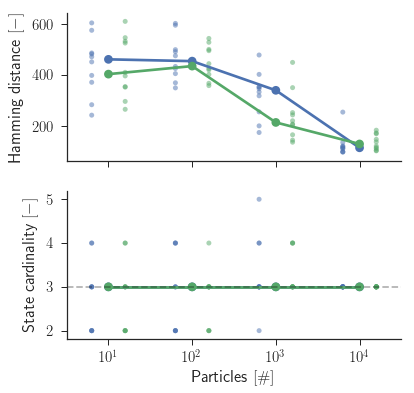

In [273]:
data1 = pd.melt(hdDF, "model", var_name="particles")
data2 = pd.melt(cDF, "model", var_name="particles")

# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(2, sharex=True,figsize=(6,6))
sns.despine()

## TOP

# Show each observation with a scatterplot
sns.stripplot(x="particles", y="value",  hue="model",
              data=data1, dodge=True, jitter=False, palette='deep',
              alpha=.5,size=5, marker='o',zorder=1,ax=axarr[0])

# Show the conditional means
sns.pointplot(x="particles", y="value", hue="model",
              data=data1, dodge=0, join=True, palette="deep",
              estimator=np.median,
              markers="o", scale=0.85, ci=None,ax=axarr[0])

## BOTTOM

# Show each observation with a scatterplot
sns.stripplot(x="particles", y="value",  hue="model",
              data=data2, dodge=True, jitter=False, palette='deep',
              alpha=.5,size=5, marker='o',zorder=1,ax=axarr[1])

# Show the conditional means
sns.pointplot(x="particles", y="value", hue="model",
              data=data2, dodge=0, join=True, palette="deep",
              estimator=np.median,
              markers="o", scale=0.85, ci=None,ax=axarr[1])

# red line
axarr[1].axhline(y=3, alpha=0.3,color='k', linestyle='--')

# Tick stuff
axarr[0].set_xlabel('')
axarr[1].set_xlabel('Particles $[\#]$')
# axarr[0].set_ylim(0,700)
axarr[0].set_ylabel('Hamming distance $[-]$',labelpad=8)
axarr[1].set_ylabel('State cardinality $[-]$',labelpad=8)
# ax.set_yticks([0.0,0.1])

# Improve the legend 
handles, labels = axarr[0].get_legend_handles_labels()
axarr[0].legend(handles[2:], labels[2:],handletextpad=0, columnspacing=1,
          loc="lower left", ncol=1, frameon=False,prop={'size':14})
axarr[1].legend_.remove()
axarr[0].legend_.remove()
plt.show()

In [274]:
fig.savefig('poisson-durations' + '.pdf',bbox_inches='tight')